<a href="https://colab.research.google.com/github/tashramsden/100_days_python/blob/main/day-79_semmelweis_handwashing/day_79_semmelweis_handwashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Summary:**

* How to use histograms to visualise distributions

* How to superimpose histograms on top of each other even when the data series have different lengths

* How to smooth out kinks in a histogram and visualise a distribution with a Kernel Density Estimate (KDE)

* How to improve a KDE by specifying boundaries on the estimates

* How to use scipy and test for statistical significance by looking at p-values.

* How to highlight different parts of a time series chart in Matplotib.

* How to add and configure a Legend in Matplotlib.

* Use NumPy's .where() function to process elements depending on a condition.

# Setup and Context

<img src="https://i.imgur.com/gugIA5r.png" width=700>

### Introduction

Dr Ignaz Semmelweis was a Hungarian physician born in 1818 who worked in the Vienna General Hospital. In the past people thought of illness as caused by "bad air" or evil spirits. But in the 1800s Doctors started looking more at anatomy, doing autopsies and started making arguments based on data. Dr Semmelweis suspected that something was going wrong with the procedures at Vienna General Hospital. Semmelweis wanted to figure out why so many women in maternity wards were dying from childbed fever (i.e., [puerperal fever](https://en.wikipedia.org/wiki/Postpartum_infections)).

<img src=https://i.imgur.com/lSyNUwR.png width=700>

Today you will become Dr Semmelweis. This is your office 👆. You will step into Dr Semmelweis' shoes and analyse the same data collected from 1841 to 1849.

### The Data Source

Dr Semmelweis published his research in 1861. I found the scanned pages of the [full text with the original tables in German](http://www.deutschestextarchiv.de/book/show/semmelweis_kindbettfieber_1861), but an excellent [English translation can be found here](http://graphics8.nytimes.com/images/blogs/freakonomics/pdf/the%20etiology,%20concept%20and%20prophylaxis%20of%20childbed%20fever.pdf).

<img src=https://i.imgur.com/6HfLtaC.png width=500>

### Upgrade plotly (only Google Colab Notebook)

Google Colab may not be running the latest version of plotly. If you're working in Google Colab, uncomment the line below, run the cell, and restart your notebook server. 

In [ ]:
# %pip install --upgrade plotly

     |████████████████████████████████| 20.6MB 44.1MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


### Import Statements

In [264]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats

### Notebook Presentation

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

# Create locators for ticks on the time axis

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Read the Data

In [122]:
df_yearly = pd.read_csv('annual_deaths_by_clinic.csv')
# parse_dates avoids DateTime conversion later
df_monthly = pd.read_csv('monthly_deaths.csv', 
                      parse_dates=['date'])

# Preliminary Data Exploration

**Challenge**: Check out these two DataFrames ☝️. 
* What is the shape of df_yearly and df_monthly? How many rows and columns?
* What are the column names?
* Which years are included in the dataset?
* Are there any NaN values or duplicates?
* What were the average number of births that took place per month?
* What were the average number of deaths that took place per month?

**df_yearly:**

In [30]:
df_yearly

,year,births,deaths,clinic
0,1841,3036,237,clinic 1
1,1842,3287,518,clinic 1
2,1843,3060,274,clinic 1
3,1844,3157,260,clinic 1
4,1845,3492,241,clinic 1
5,1846,4010,459,clinic 1
6,1841,2442,86,clinic 2
7,1842,2659,202,clinic 2
8,1843,2739,164,clinic 2
9,1844,2956,68,clinic 2


In [9]:
df_yearly.shape

(12, 4)

In [15]:
print(df_yearly.year.min())  # 1841-1846
df_yearly.year.max()

1841


1846

**df_monthly:**

In [20]:
df_monthly.head()

,date,births,deaths
0,1841-01-01,254,37
1,1841-02-01,239,18
2,1841-03-01,277,12
3,1841-04-01,255,4
4,1841-05-01,255,2


In [21]:
df_monthly.shape

(98, 3)

In [23]:
print(df_monthly.date.min())  # 1841-1849
df_monthly.date.max()

1841-01-01 00:00:00


Timestamp('1849-03-01 00:00:00')

### Check for Nan Values and Duplicates

In [32]:
print(f"Any yearly NaN? {df_yearly.isna().values.any()}")
print(f"Any yearly duplicates? {df_yearly.duplicated().values.any()}\n")

print(f"Any monthly NaN? {df_monthly.isna().values.any()}")
print(f"Any monthly duplicates? {df_monthly.duplicated().values.any()}")

Any yearly NaN? False
Any yearly duplicates? False

Any monthly NaN? False
Any monthly duplicates? False


In [34]:
df_yearly.info()  # (this also tells about NaN)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    12 non-null     int64 
 1   births  12 non-null     int64 
 2   deaths  12 non-null     int64 
 3   clinic  12 non-null     object
dtypes: int64(3), object(1)
memory usage: 512.0+ bytes
None


### Descriptive Statistics

In [19]:
df_yearly.describe()  # yearly: ave of 3152 births and 223 deaths

,year,births,deaths
count,12.00,12.00,12.00
mean,"1,843.50","3,152.75",223.33
std,1.78,449.08,145.38
min,"1,841.00","2,442.00",66.00
25%,"1,842.00","2,901.75",100.25
50%,"1,843.50","3,108.50",219.50
75%,"1,845.00","3,338.25",263.50
max,"1,846.00","4,010.00",518.00


In [26]:
df_monthly.describe()  # monthly: ave of 267 births and 22 deaths

,births,deaths
count,98.00,98.00
mean,267.00,22.47
std,41.77,18.14
min,190.00,0.00
25%,242.50,8.00
50%,264.00,16.50
75%,292.75,36.75
max,406.00,75.00


### Percentage of Women Dying in Childbirth

**Challenge**: How dangerous was childbirth in the 1840s in Vienna? 

* Using the annual data, calculate the percentage of women giving birth who died throughout the 1840s at the hospital.


In comparison, the United States recorded 18.5 maternal deaths per 100,000 or 0.018% in 2013 [(source).](
https://en.wikipedia.org/wiki/Maternal_death#:~:text=The%20US%20has%20the%20%22highest,17.8%20per%20100%2C000%20in%202009)

In [37]:
prob = df_yearly.deaths.sum() / df_yearly.births.sum() * 100
print(f"Percentage chance of dying in childbirth in 1940s Vienna: {prob:.3}%")

Percentage chance of dying in childbirth in 1940s Vienna: 7.08%


# Visualise the Total Number of Births 🤱 and Deaths 💀 over Time

### Plot the Monthly Data on Twin Axes

**Challenge**: Create a [Matplotlib chart](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.plot.html) with twin y-axes. It should look something like this:

<img src=https://i.imgur.com/F9DOJxx.png width=700>

* Format the x-axis using locators for the years and months (Hint: we did this in the Google Trends notebook)
* Set the range on the x-axis so that the chart lines touch the y-axes
* Add gridlines
* Use `skyblue` and `crimson` for the line colours
* Use a dashed line style for the number of deaths
* Change the line thickness to 3 and 2 for the births and deaths respectively. 
* Do you notice anything in the late 1840s?

In [78]:
# Create locators for ticks on the time axis
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y') 

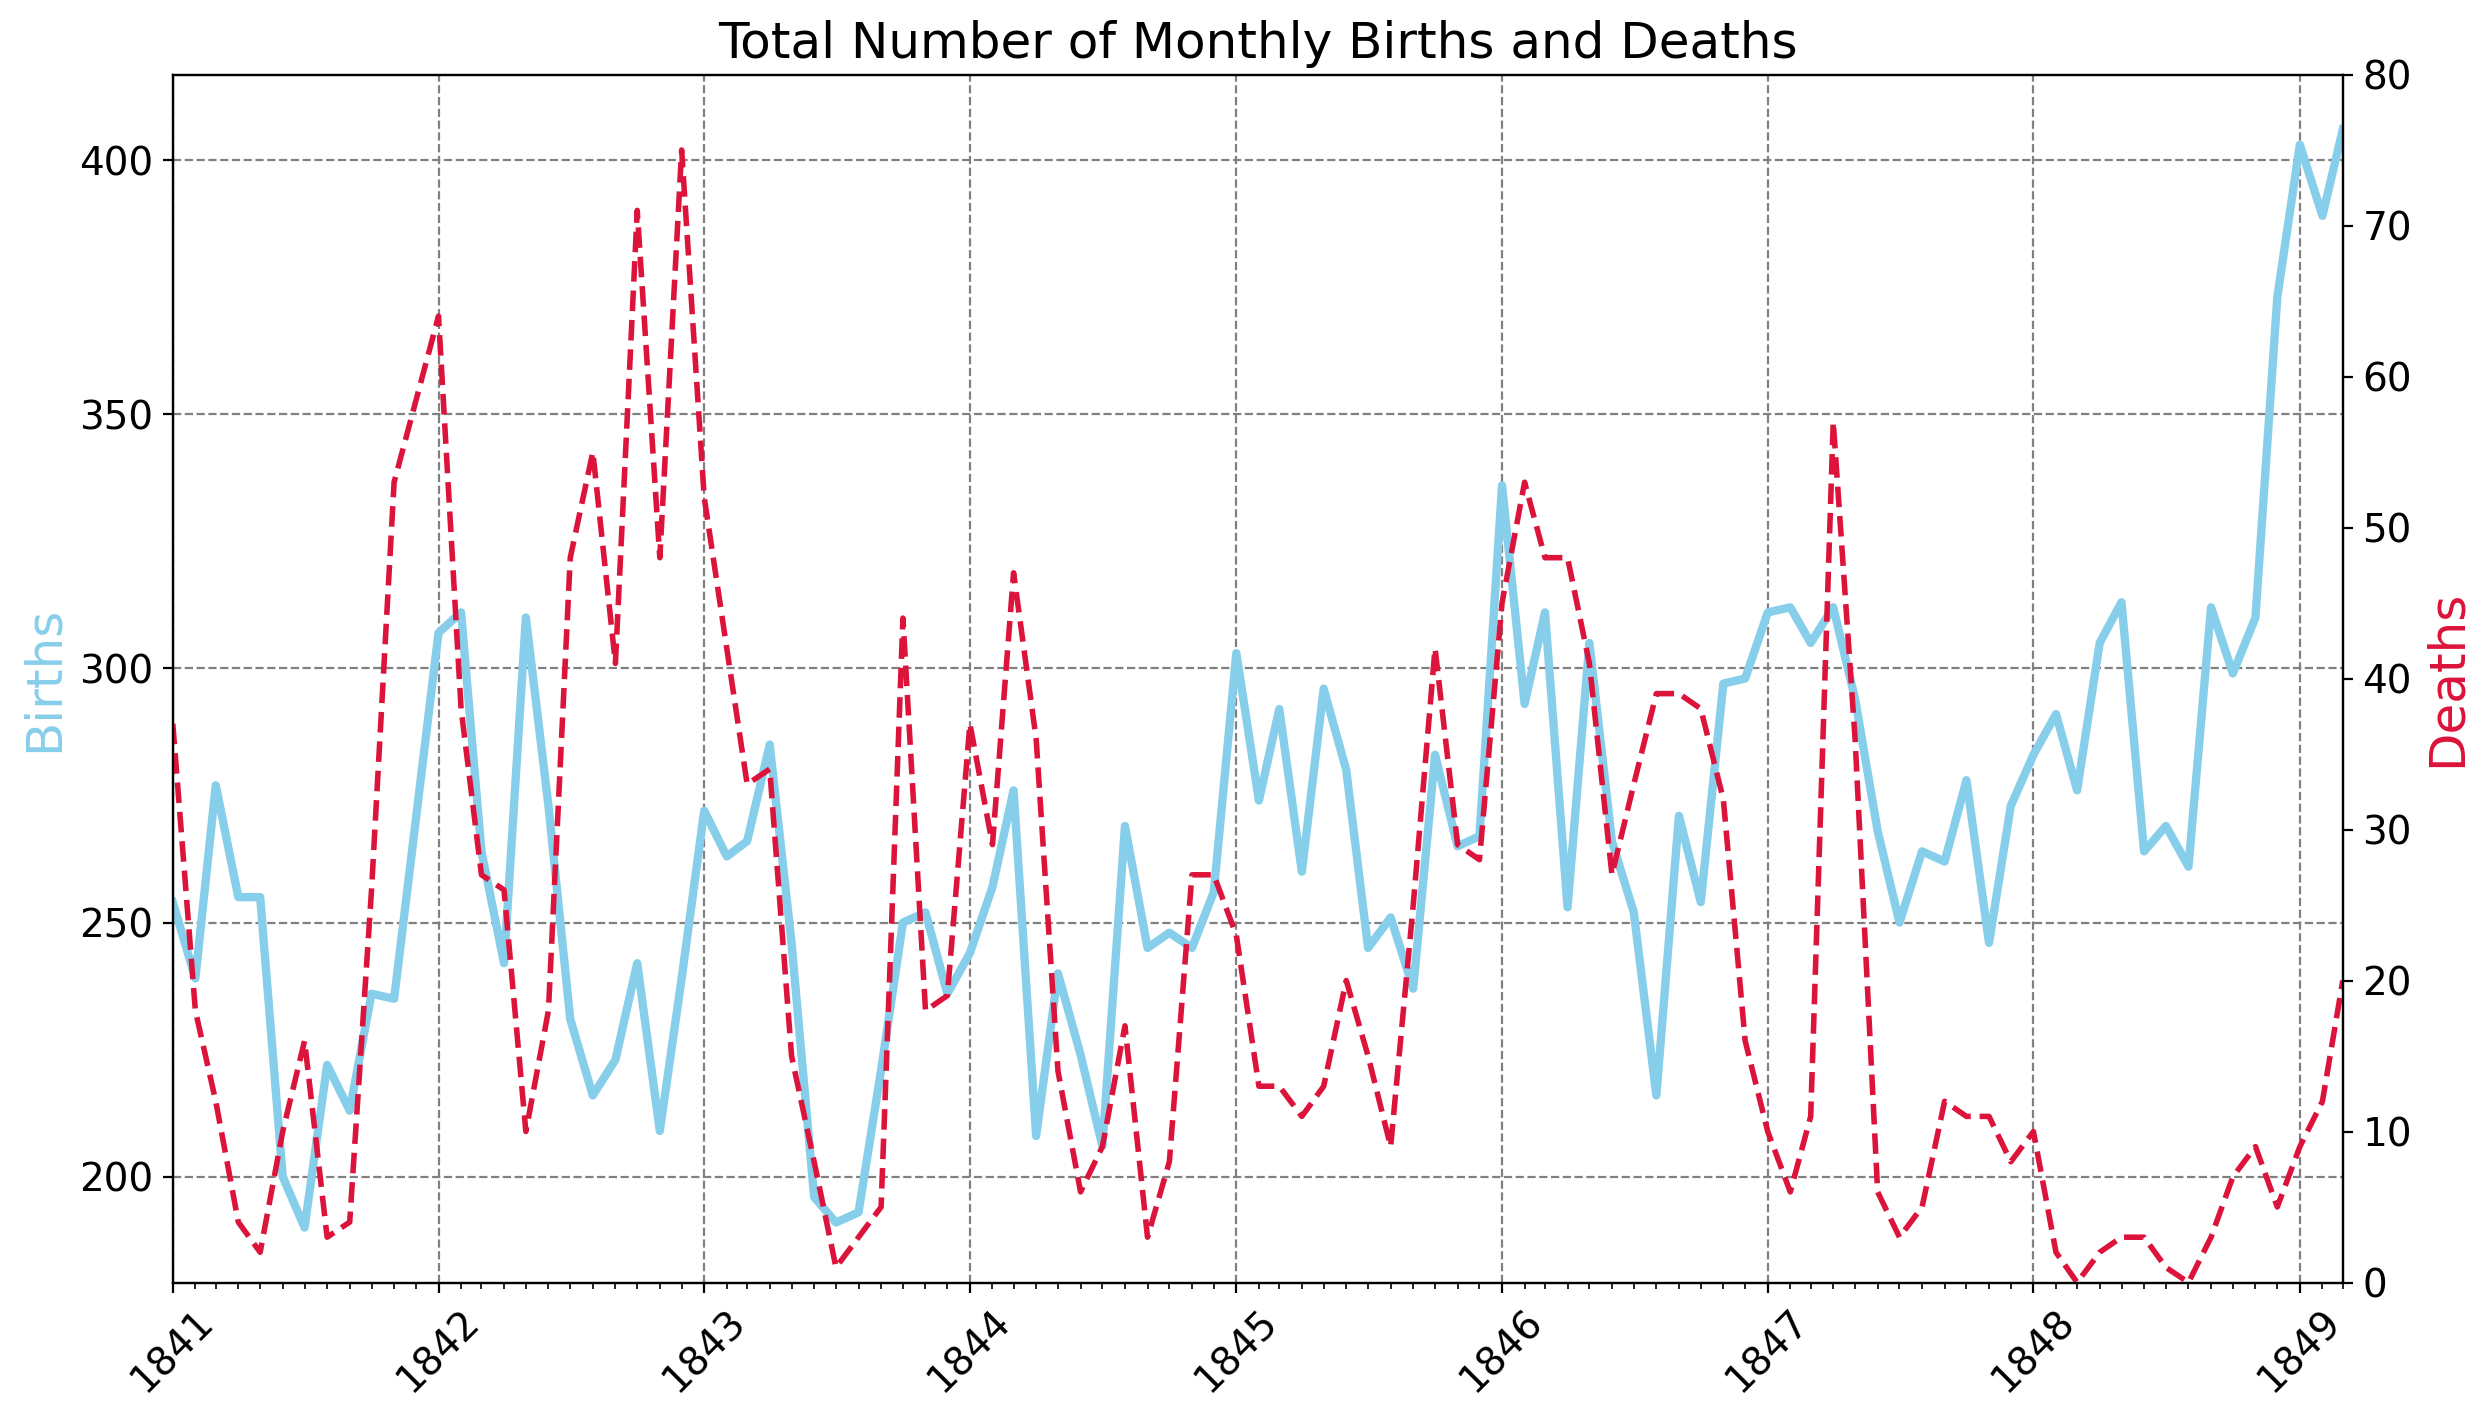

In [102]:
plt.figure(figsize=(14, 8), dpi=200)
plt.title('Total Number of Monthly Births and Deaths', fontsize=18)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelsize=14)

ax1.grid(color="grey", linestyle="--")

ax1.set_ylabel("Births", color="skyblue", size=18)
ax2.set_ylabel("Deaths", color="crimson", size=18)
ax2.set_ylim(0, 80)

# Use locators for x axis
ax1.set_xlim([df_monthly.date.min(), df_monthly.date.max()])
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)

ax1.plot(df_monthly.date, 
         df_monthly.births, 
         color="skyblue", 
         linewidth=3)
ax2.plot(df_monthly.date, 
         df_monthly.deaths, 
         color="crimson", 
         linestyle="--", 
         linewidth=2)

plt.show()


What we see is that something happened after 1847. The total number of deaths seems to have dropped, despite an increasing number of births.

# The Yearly Data Split by Clinic

Now let's look at the annual data instead. 

There are two maternity wards at the Vienna General Hospital: clinic 1 and clinic 2. Clinic 1 was staffed by all-male doctors and medical students, and clinic 2 was staffed by female midwives.

**Challenge**: Use plotly to create line charts of the births and deaths of the two different clinics at the Vienna General Hospital. 
* Which clinic is bigger or more busy judging by the number of births?
* Has the hospital had more patients over time? 
* What was the highest number of deaths recorded in clinic 1 and clinic 2?

In [109]:
births = px.line(df_yearly,
                  x = "year",
                  y = "births",
                  color = "clinic",
                 title = "Total Yearly Births by Clinic")

births.update_layout(xaxis_title = "Year",
                     yaxis_title = "Births")

births.show()

We see that more and more women gave birth at the hospital over the years. Clinic 1, which was staffed by male doctors and medical students, was also the busier or simply the larger ward. More births took place in clinic 1 than in clinic 2.

In [110]:
deaths = px.line(df_yearly,
                 x = "year",
                 y = "deaths",
                 color = "clinic",
                 title = "Total Yearly Deaths by Clinic")

deaths.update_layout(xaxis_title = "Year",
                     yaxis_title = "Deaths")

deaths.show()

We also see that, not only were more people born in clinic 1, more people also died in clinic 1.

To compare like for like, we need to look at the proportion of deaths per clinic.

### Calculate the Proportion of Deaths at Each Clinic

**Challenge**: Calculate the proportion of maternal deaths per clinic. That way we can compare like with like. 
* Work out the percentage of deaths for each row in the `df_yearly` DataFrame by adding a column called "pct_deaths". 
* Calculate the average maternal death rate for clinic 1 and clinic 2 (i.e., the total number of deaths per the total number of births).
* Create another plotly line chart to see how the percentage varies year over year with the two different clinics.
* Which clinic has a higher proportion of deaths?
* What is the highest monthly death rate in clinic 1 compared to clinic 2?

In [123]:
df_yearly["pct_deaths"] = df_yearly.deaths / df_yearly.births * 100
df_yearly

,year,births,deaths,clinic,pct_deaths
0,1841,3036,237,clinic 1,7.81
1,1842,3287,518,clinic 1,15.76
2,1843,3060,274,clinic 1,8.95
3,1844,3157,260,clinic 1,8.24
4,1845,3492,241,clinic 1,6.90
5,1846,4010,459,clinic 1,11.45
6,1841,2442,86,clinic 2,3.52
7,1842,2659,202,clinic 2,7.60
8,1843,2739,164,clinic 2,5.99
9,1844,2956,68,clinic 2,2.30


In [138]:
clinic1 = df_yearly[df_yearly.clinic == "clinic 1"]
clinic1_ave = clinic1.deaths.sum() / clinic1.births.sum() * 100
print(f"Average death rate in clinic 1 was: {clinic1_ave:.3}%")

Average death rate in clinic 1 was: 9.92%


In [140]:
clinic2 = df_yearly[df_yearly.clinic == "clinic 2"]
clinic2_ave = clinic2.deaths.sum() / clinic2.births.sum() * 100
print(f"Average death rate in clinic 2 was: {clinic2_ave:.3}%")

Average death rate in clinic 2 was: 3.88%


### Plotting the Proportion of Yearly Deaths by Clinic

In [141]:
pct_deaths_plot = px.line(df_yearly,
                          x = "year",
                          y = "pct_deaths",
                          color = "clinic",
                          title = "Percentage of Yearly Deaths by Clinic")

pct_deaths_plot.update_layout(xaxis_title = "Year",
                              yaxis_title = "Percentage Deaths (%)")

pct_deaths_plot.show()

1842 was a rough year. About 16% of women died in clinic 1 and about 7.6% of women died in clinic 2.

Clinic 2 had a consistently lower death rate than clinic 1. This is what puzzled and frustrated Dr Semmelweis.

# The Effect of Handwashing

At first, Dr Semmelweis thought that the position of the women giving birth was the issue. In clinic 2, the midwives' clinic, women gave birth on their sides. In the doctors' clinic, women gave birth on their backs. So, Dr. Semmelweis, had women in the doctors' clinic give birth on their sides. However, this had no effect on the death rate.

Next, Dr Semmelweis noticed that whenever someone on the ward died, a priest would walk through clinic 1, past the women's beds ringing a bell 🔔. Perhaps the priest and the bell ringing terrified the women so much after birth that they developed a fever, got sick and died. Dr Semmelweis had the priest change his route and stop ringing the bell 🔕. Again, this had no effect.

At this point, Dr Semmelweis was so frustrated he went on holiday to Venice. Perhaps a short break would clear his head. When Semmelweis returned from his vacation, he was told that one of his colleagues, a pathologist, had fallen ill and died. His friend had pricked his finger while doing an autopsy on a woman who had died from childbed fever and subsequently got very sick himself and died. 😮

Looking at the pathologist's symptoms, Semmelweis realised the pathologist died from the same thing as the women he had autopsied.  This was his breakthrough: anyone could get sick from childbed fever, not just women giving birth!

This is what led to Semmelweis' new theory. Perhaps there were little pieces or particles of a corpse that the doctors and medical students were getting on their hands while dissecting the cadavers during an autopsy. And when the doctors delivered the babies in clinic 1, these particles would get inside the women giving birth who would then develop the disease and die.

In June 1847, Dr Semmelweis ordered everyone on his medical staff to start cleaning their hands and instruments not just with soap and water but with a chlorine solution (he didn't know it at the time, but chlorine is an amazing disinfectant). The reason Dr Semmelweis actually chose the chlorine was that he wanted to get rid of any smell on doctors' hands after an autopsy. No one knew anything about bacteria, germs or viruses at the time.

In [142]:
# Date when handwashing was made mandatory
handwashing_start = pd.to_datetime('1847-06-01')

**Challenge**: 
* Add a column called "pct_deaths" to `df_monthly` that has the percentage of deaths per birth for each row. 
* Create two subsets from the `df_monthly` data: before and after Dr Semmelweis ordered washing hand.
* Calculate the average death rate prior to June 1947.
* Calculate the average death rate after June 1947.

In [144]:
df_monthly["pct_deaths"] = df_monthly.deaths / df_monthly.births * 100
df_monthly.head()

,date,births,deaths,pct_deaths
0,1841-01-01,254,37,14.57
1,1841-02-01,239,18,7.53
2,1841-03-01,277,12,4.33
3,1841-04-01,255,4,1.57
4,1841-05-01,255,2,0.78


In [152]:
before = df_monthly[df_monthly.date < handwashing_start]
before_ave = before.deaths.sum() / before.births.sum() * 100
print(f"Average death rate before handwashing: {before_ave:.4}%")

Average death rate before handwashing: 10.53%


In [154]:
after = df_monthly[df_monthly.date >= handwashing_start]
after_ave = after.deaths.sum() / after.births.sum() * 100
print(f"Average death rate after handwashing: {after_ave:.3}%")

Average death rate after handwashing: 2.15%


### Calculate a Rolling Average of the Death Rate

**Challenge**: Create a DataFrame that has the 6 month rolling average death rate prior to mandatory handwashing.

*Hint*: You'll need to set the dates as the index in order to avoid the date column being dropped during the calculation.

In [156]:
roll_df = before.set_index("date")
roll_df = roll_df.rolling(window=6).mean()

### Highlighting Subsections of a Line Chart

**Challenge**: Copy-paste and then modify the Matplotlib chart from before to plot the monthly death rates (instead of the total number of births and deaths). The chart should look something like this:

<img src=https://i.imgur.com/X6TQe0R.png width=500>

* Add 3 seperate lines to the plot: the death rate before handwashing, after handwashing, and the 6-month moving average before handwashing.
* Show the monthly death rate before handwashing as a thin dashed black line. 
* Show the moving average as a thicker, crimon line.
* Show the rate after handwashing as a skyblue line with round markers. 
* Look at the [code snippet in the documentation to see how you can add a legend](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html) to the chart.

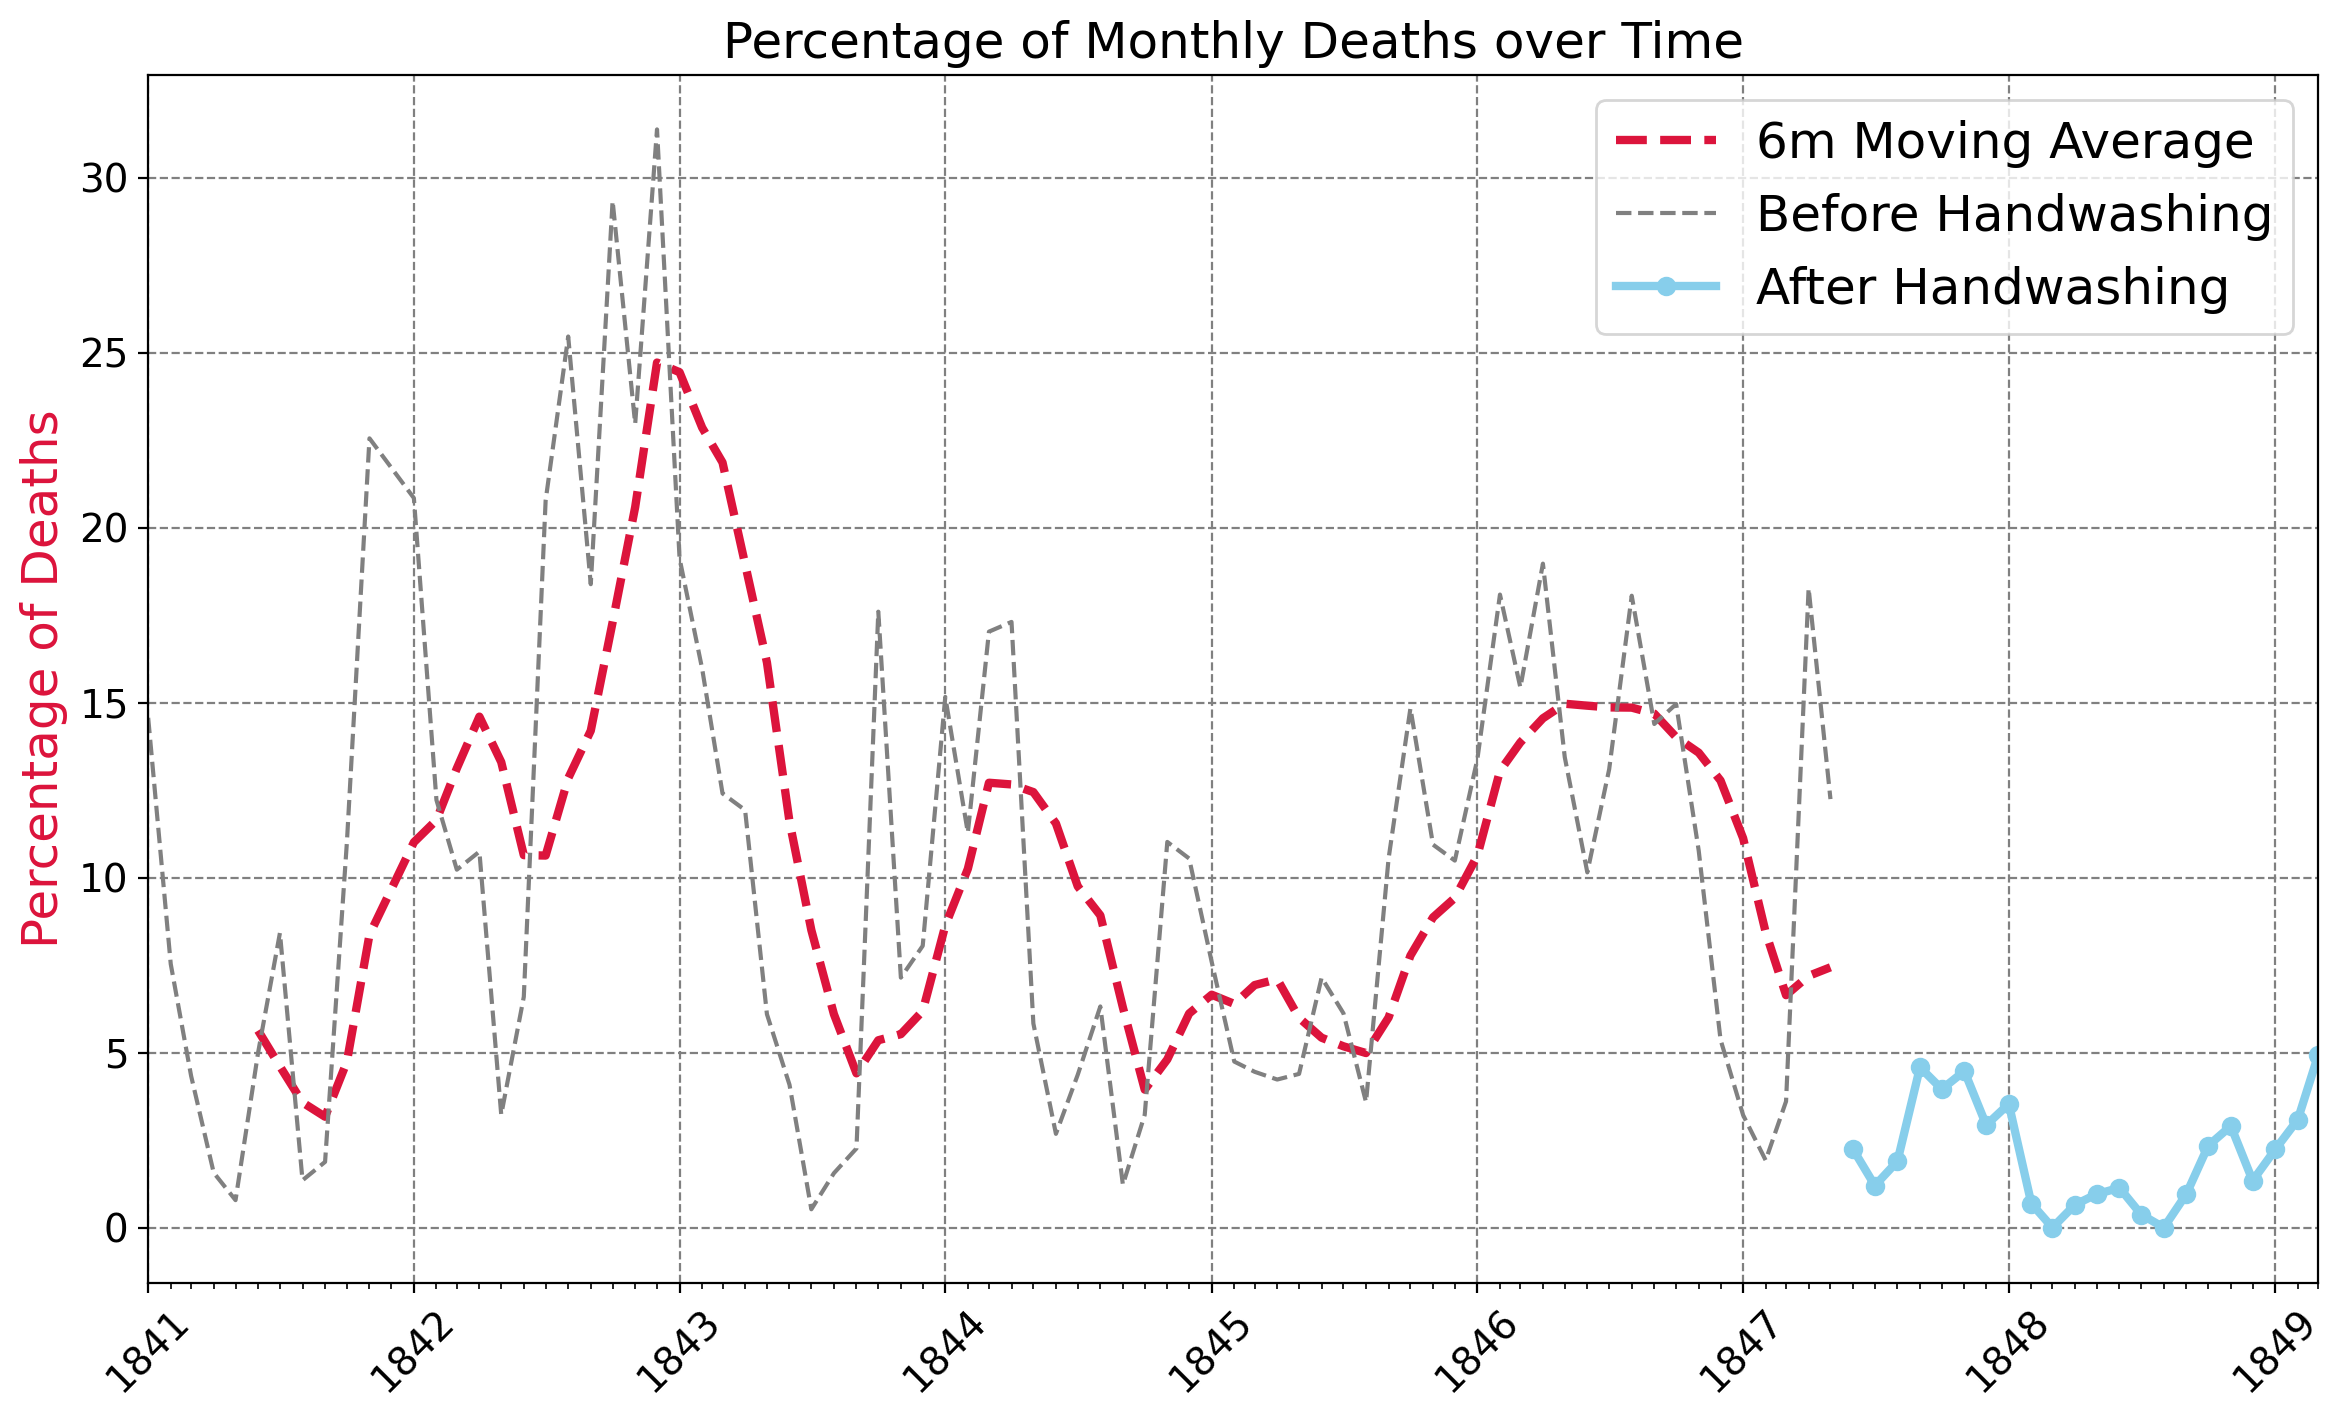

In [188]:
plt.figure(figsize=(14, 8), dpi=200)
plt.title('Percentage of Monthly Deaths over Time', fontsize=18)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.grid(color="grey", linestyle="--")

plt.ylabel("Percentage of Deaths", color="crimson", size=18)

ax = plt.gca()
ax.set_xlim([df_monthly.date.min(), df_monthly.date.max()])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# the commas after the line names are NECESSARY
roll_line, = plt.plot(roll_df.index,
                      roll_df.pct_deaths, 
                      color="crimson", 
                      linewidth=3,
                      linestyle="--",
                      label="6m Moving Average")
before_line, = plt.plot(before.date,
                        before.pct_deaths,
                        color="grey",
                        linewidth=1.5,
                        linestyle="--",
                        label="Before Handwashing")
after_line, = plt.plot(after.date,
                       after.pct_deaths,
                       color="skyblue",
                       linewidth=3,
                       marker="o",
                       label="After Handwashing")

plt.legend(handles=[roll_line, before_line, after_line], fontsize=18)

plt.show()

### Statistics - Calculate the Difference in the Average Monthly Death Rate

**Challenge**:
* What was the average percentage of monthly deaths before handwashing? 
* What was the average percentage of monthly deaths after handwashing was made obligatory?
* By how much did handwashing reduce the average chance of dying in childbirth in percentage terms?
* How do these numbers compare to the average for all the 1840s that we calculated earlier? 
* How many times lower are the chances of dying after handwashing compared to before?

In [204]:
bef_ave_death = before.pct_deaths.mean()
aft_ave_death = after.pct_deaths.mean()

print(f"Average percentage of monthly deaths before handwashing: {bef_ave_death:.4}%")
print(f"Average percentage of monthly deaths after handwashing: {aft_ave_death:.3}%\n")
print(f"Handwashing reduced average chance of dying in childbirth by {bef_ave_death - aft_ave_death:.3}%")
print(f"After handwashing was introduced, women were {bef_ave_death / aft_ave_death:.3} times less likely to die during childbirth.")

Average percentage of monthly deaths before handwashing: 10.5%
Average percentage of monthly deaths after handwashing: 2.11%

Handwashing reduced average chance of dying in childbirth by 8.4%
After handwashing was introduced, women were 4.98 times less likely to die during childbirth.


### Use Box Plots to Show How the Death Rate Changed Before and After Handwashing

**Challenge**: 
* Use [NumPy's `.where()` function](https://numpy.org/doc/stable/reference/generated/numpy.where.html) to add a column to `df_monthly` that shows if a particular date was before or after the start of handwashing. 
* Then use plotly to create box plot of the data before and after handwashing. 
* How did key statistics like the mean, max, min, 1st and 3rd quartile changed as a result of the new policy?



In [218]:
df_monthly["when"] = np.where(df_monthly.date < handwashing_start, "Before", "After")
# df_monthly

In [220]:
handwash_box = px.box(df_monthly,
                      x = "when",
                      y = "pct_deaths",
                      color = "when",
                      title = "Percentage Deaths Before and After Handwashing")

handwash_box.update_layout(xaxis_title='Washing Hands?',
                           yaxis_title='Percentage of Monthly Deaths',)

handwash_box.show()

The plot shows us the same data as our Matplotlib chart, but from a different perspective. Here we also see the massive spike in deaths in late 1842. Over 30% of women who gave birth that month died in hospital. What we also see in the box plot is how not only did the average death rate come down, but so did the overall range - we have a lower max and 3rd quartile too. Let's take a look at a histogram to get a better sense of the distribution.

### Use Histograms to Visualise the Monthly Distribution of Outcomes

**Challenge**: Create a [plotly histogram](https://plotly.com/python/histograms/) to show the monthly percentage of deaths. 

* Use docs to check out the available parameters. Use the [`color` parameter](https://plotly.github.io/plotly.py-docs/generated/plotly.express.histogram.html) to display two overlapping histograms.
* The time period of handwashing is shorter than not handwashing. Change `histnorm` to `percent` to make the time periods comparable. 
* Make the histograms slighlty transparent
* Experiment with the number of bins on the histogram. Which number work well in communicating the range of outcomes?
* Just for fun, display your box plot on the top of the histogram using the `marginal` parameter. 

In [242]:
handwash_hist = px.histogram(df_monthly.pct_deaths,
                             color = df_monthly.when,
                             histnorm = "percent",
                             opacity = 0.6,
                             barmode = "overlay", 
                             nbins = 30,
                             marginal = "box")

handwash_hist.update_layout(xaxis_title='Percentage of Monthly Deaths',
                            yaxis_title='Count')

handwash_hist.show()

Only about 98 data points, so our histogram looks a bit jagged - not a smooth bell-shaped curve. However, we can estimate what the distribution would look like with a Kernel Density Estimate (KDE).

### Use a Kernel Density Estimate (KDE) to visualise a smooth distribution

**Challenge**: Use [Seaborn's `.kdeplot()`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) to create two kernel density estimates of the `pct_deaths`, one for before handwashing and one for after. 

* Use the `shade` parameter to give your two distributions different colours. 
* What weakness in the chart do you see when you just use the default parameters?
* Use the `clip` parameter to address the problem. 


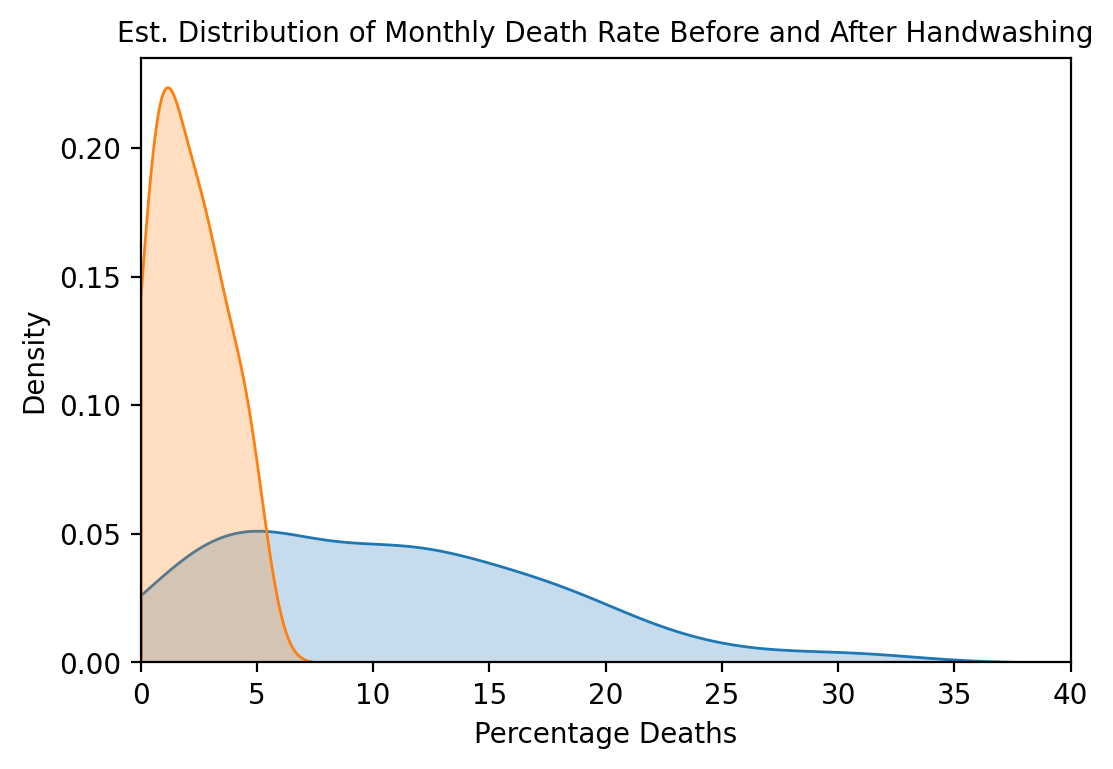

In [263]:
plt.figure(dpi=200)

# without clip - the distributions will include negative percentage deaths
bef = sns.kdeplot(before.pct_deaths, shade=True, clip=(0, 50))
aft = sns.kdeplot(after.pct_deaths, shade=True, clip=(0, 50))

plt.xlim(0, 40)
plt.title('Est. Distribution of Monthly Death Rate Before and After Handwashing',
          fontsize=10)

bef.set(xlabel = "Percentage Deaths")

plt.show()

Now that we have an idea of what the two distributions look like, we can further strengthen our argument for handwashing by using a statistical test. We can test whether our distributions ended up looking so different purely by chance (i.e., the lower death rate is just an accident) or if the 8.4% difference in the average death rate is statistically significant.

### Use a T-Test to Show Statistical Significance

**Challenge**: Use a t-test to determine if the differences in the means are statistically significant or purely due to chance. 

If the p-value is less than 1% then we can be 99% certain that handwashing has made a difference to the average monthly death rate. 

* Import `stats` from scipy
* Use the [`.ttest_ind()` function](https://docs.scipy.org/]doc/scipy/reference/generated/scipy.stats.ttest_ind.html) to calculate the t-statistic and the p-value
* Is the difference in the average proportion of monthly deaths statistically significant at the 99% level? 



In [271]:
# stats.ttest_ind(a = before.pct_deaths, 
#                 b = after.pct_deaths)

t_stat, p_value = stats.ttest_ind(a=before.pct_deaths, 
                                  b=after.pct_deaths)
print(f't-statstic is {t_stat:.4}')
print(f'p-palue is {p_value:.10f}')

t-statstic is 5.512
p-palue is 0.0000002985


So percentage deaths after handwashing introduced was significantly reduced.

What do you conclude from your analysis, Doctor? 😊

<img src=https://i.imgur.com/rvjNVzQ.gif>

Gather round, gather round. Now I'll tell you how our story ends. Despite the incredible evidence in favour of Dr Semmelweis' theory - that childbed fever was caused by some "substance" (which today we know as bacteria) from autopsy room corpses - was rejected by the medical community at the time. But why?! 

Part of the reason is that Semmelweis was not very tactful. He made it look like doctors were giving childbed fever to women (which they in fact were). This is not something people wanted to hear.

However, he also published his data in the form of long tables without any data visualisations. The long tables made it very hard to see what's actually going on. Also, at the time statistics and statistical arguments were quite uncommon in the field of medicine.

Eventually, Dr Semmelweis belligerent campaigning made him some powerful and influential enemies. He lost his job at the Vienna hospital, and doctors gave up washing their hands with chlorine. As Dr Semmelweis grew older he got even angrier and eventually quite "strange". This was either the immense frustration or possibly a result of another disease like Alzheimer's or syphilis. In 1965, at the age of 47, Dr Semmelweis was committed to a mental asylum. And at the asylum, he was probably beaten since he eventually died of sepsis, a complication of an infection in the bloodstream. The tragic irony is that sepsis is a similar kind of disease that he fought so hard to prevent in women who died from childbed fever. It wasn't until 20 years later with Louis Pasteur's work on germ theory that Dr Semmelweis' work gained acceptance. RIP Dr Semmelweis.